In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# 12분
# !unzip '/content/drive/MyDrive/input/happy-whale-and-dolphin.zip' -d '/content/data/'

In [ ]:
# !kaggle datasets init -p /tmp/happywhale-tfrecords-v2

Data package template written to: /tmp/happywhale-tfrecords-v2/dataset-metadata.json


In [ ]:
# !kaggle datasets create -p /tmp/happywhale-tfrecords-v2

# Cutting image

In [ ]:
from glob import glob
import os
import pandas as pd
import numpy as np
import shutil
from tqdm.auto import tqdm

import matplotlib.pyplot as plt
from matplotlib.patches import Patch, Rectangle

In [ ]:
train_cut = pd.read_csv('/content/drive/Othercomputers/MyComputer/workspace/dl_whale_classification/train2.csv')
test_cut = pd.read_csv('/content/drive/Othercomputers/MyComputer/workspace/dl_whale_classification/test2.csv')

In [ ]:
train_cut.fillna('0 0 0 0', inplace=True)
test_cut.fillna('0 0 0 0', inplace=True)

In [ ]:
shutil.copyfile('/content/data/train.csv', 'train.csv')

'train.csv'

In [ ]:
def make_croped_images(df, mode='train'):
    cnt = 0
    data_root = '/content/data/'
    os.makedirs(data_root + f'{mode}_croped', exist_ok=True)
    for i in tqdm(sorted(glob(data_root + f'{mode}_images/*'))):
        file_name = i.split('/')[-1]
        x,y,w,h = list(map(int,df[df['image']==file_name]['box'].values[0].split()))
        if (x+y+w+h) == 0:
            shutil.copyfile(f'{data_root}{mode}_images/{file_name}', 
                            f'{data_root}{mode}_croped/{file_name}')
        else:
            img = cv2.imread(f'{data_root}{mode}_images/{file_name}')
            img_ = img[y:y+h,x:x+w,:]
            cv2.imwrite(f'{data_root}{mode}_croped/{file_name}',img_)
        cnt += 1

In [ ]:
make_croped_images(train_cut, 'train')
make_croped_images(test_cut, 'test')

# Json

In [2]:
root_dir = '/content/drive/Othercomputers/MyComputer/workspace/dl_whale_classification'

In [3]:
!cp {root_dir}/kaggle.json /content/

In [4]:
import os, json, random, cv2
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf, re, math
from tqdm import tqdm

In [5]:
%%time

### Create Kaggle Dataset if not exists 

DATASET_NAME = f'happywhale-tfrecords-v2'

!rm -r /tmp/{DATASET_NAME}

os.makedirs(f'/tmp/{DATASET_NAME}', exist_ok=True)

with open('/content/kaggle.json') as f:
    kaggle_creds = json.load(f)
    
os.environ['KAGGLE_USERNAME'] = kaggle_creds['username']
os.environ['KAGGLE_KEY'] = kaggle_creds['key']

!kaggle datasets init -p /tmp/{DATASET_NAME}


with open(f'/tmp/{DATASET_NAME}/dataset-metadata.json') as f:
    dataset_meta = json.load(f)
dataset_meta['id'] = f'ks2019/{DATASET_NAME}'
dataset_meta['title'] = DATASET_NAME
with open(f'/tmp/{DATASET_NAME}/dataset-metadata.json', "w") as outfile:
    json.dump(dataset_meta, outfile)
print(dataset_meta)

!cp /tmp/{DATASET_NAME}/dataset-metadata.json /tmp/{DATASET_NAME}/meta.json
!ls /tmp/{DATASET_NAME}

!kaggle datasets create -u -p /tmp/{DATASET_NAME} 

rm: cannot remove '/tmp/happywhale-tfrecords-v2': No such file or directory
Data package template written to: /tmp/happywhale-tfrecords-v2/dataset-metadata.json
{'title': 'happywhale-tfrecords-v2', 'id': 'ks2019/happywhale-tfrecords-v2', 'licenses': [{'name': 'CC0-1.0'}]}
dataset-metadata.json  meta.json
Starting upload for file meta.json
100% 111/111 [00:01<00:00, 71.5B/s]
Upload successful: meta.json (111B)
Dataset creation error: Dataset url's dataset slugs and hashlink are all null
CPU times: user 49.4 ms, sys: 55.5 ms, total: 105 ms
Wall time: 3.39 s


# Preprocessing - resize

In [ ]:
# from glob import glob
# import cv2
# from google.colab.patches import cv2_imshow
# from tqdm.auto import tqdm

In [ ]:
# def make_resize(image_size=256, mode='train'):
#     image_size = 256
#     directory = f'/content/data/{mode}_images_{image_size}'
#     os.makedirs(directory, exist_ok=True)
#     for i in tqdm(sorted(glob(f'/content/data/{mode}_images/*'))):
#         file_name = i.split('/')[-1]
#         img = cv2.imread(i)
#         img = cv2.resize(img, (image_size, image_size))
#         cv2.imwrite(directory+'/'+file_name, img)

In [ ]:
# make_resize(256, 'train')
# make_resize(256, 'test')

100%|██████████| 27956/27956 [32:03<00:00, 14.53it/s]


# Make tfrecords

In [ ]:
train_df = pd.read_csv(root_dir + '/skf_species_5folds.csv')
test_df = pd.read_csv('/content/drive/MyDrive/input/sample_submission.csv')
test_df['split'] = test_df.index%10
train_df.agg(['min','max','count','nunique'])

,image,species,individual_id,fold
min,00021adfb725ed.jpg,0,0,0.0
max,fffdcd42312777.jpg,29,15586,4.0
count,51033,51033,51033,51033.0
nunique,51033,30,15587,5.0


In [ ]:
def get_fold(fold):
    val_df = train_df[train_df.fold==fold].reset_index(drop=True)
    val_df['order'] = val_df.index
    val_df['order'] = val_df.groupby('individual_id').order.rank()
    val_total_counts = val_df.individual_id.value_counts().to_dict()
    val_df['total_counts'] = val_df.individual_id.map(val_total_counts)
    val_df['order'] = val_df['order']/val_df['total_counts']
    val_df = val_df.sort_values('order',ascending=False).reset_index(drop=True)
    val_df = val_df[['image','species','individual_id']]
    return val_df

In [ ]:
def _bytes_feature(value):
  """Returns a bytes_list from a string / byte."""
  if isinstance(value, type(tf.constant(0))):
    value = value.numpy() # BytesList won't unpack a string from an EagerTensor.
  return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def _float_feature(value):
  """Returns a float_list from a float / double."""
  return tf.train.Feature(float_list=tf.train.FloatList(value=[value]))

def _int64_feature(value):
  """Returns an int64_list from a bool / enum / int / uint."""
  return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

def serialize_example(image,image_name,target,species):
    feature = {
        'image': _bytes_feature(image),
        'image_name': _bytes_feature(image_name),
        'target': _int64_feature(target),
        'species': _int64_feature(species),
      }
    example_proto = tf.train.Example(features=tf.train.Features(feature=feature))
    return example_proto.SerializeToString()

In [ ]:
def create_tf_records(fold  = 0):
    df = get_fold(fold)
    tfr_filename = f'/tmp/{DATASET_NAME}/happywhale-2022-train-{fold}-{df.shape[0]}.tfrec'
    with tf.io.TFRecordWriter(tfr_filename) as writer:
        for i,row in df.iterrows():
            image_id = row.image
            target = row.individual_id
            species = row.species
            image_path = f"/content/data/train_croped/{image_id}"
            image_encoded = tf.io.read_file(image_path)
            image_name = str.encode(image_id)
            example = serialize_example(image_encoded,image_name,target,species)
            writer.write(example)

In [ ]:
# 6분
import joblib
_ = joblib.Parallel(n_jobs=8)(
        joblib.delayed(create_tf_records)(fold) for fold in tqdm(range(10))
    )

100%|██████████| 10/10 [00:00<00:00, 34.59it/s]


In [ ]:
from datetime import datetime
version_name = datetime.now().strftime("%Y%m%d-%H%M%S")
print(version_name)

20220311-060708


In [ ]:
def create_test_tf_records(fold  = 0):
    df = test_df[test_df.split==fold]
    tfr_filename = f'/tmp/{DATASET_NAME}/happywhale-2022-test-{fold}-{df.shape[0]}.tfrec'
    with tf.io.TFRecordWriter(tfr_filename) as writer:
        for i,row in df.iterrows():
            image_id = row.image
            target = -1
            species = -1
            image_path = f"/content/data/test_croped/{image_id}"
            image_encoded = tf.io.read_file(image_path)
            image_name = str.encode(image_id)
            example = serialize_example(image_encoded,image_name,target,species)
            writer.write(example)

In [ ]:
# 
import joblib
_ = joblib.Parallel(n_jobs=8)(
        joblib.delayed(create_test_tf_records)(fold) for fold in tqdm(range(10))
    )

100%|██████████| 10/10 [00:00<00:00, 38.89it/s]


# Baseline


Version changes:

Version 1:

In [6]:
import os
IS_COLAB = not os.path.exists('/kaggle/input')
print(IS_COLAB) 

True


In [7]:
import tensorflow as tf
try:
    # TPU detection. No parameters necessary if TPU_NAME environment variable is
    # set: this is always the case on Kaggle.
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.TPUStrategy(tpu)
else:
    # Default distribution strategy in Tensorflow. Works on CPU and single GPU.
    strategy = tf.distribute.get_strategy()

AUTO = tf.data.experimental.AUTOTUNE
print("REPLICAS: ", strategy.num_replicas_in_sync)

Running on TPU  grpc://10.52.239.74:8470
INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Initializing the TPU system: grpc://10.52.239.74:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.52.239.74:8470


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


REPLICAS:  8


In [8]:
if IS_COLAB:
  from google.colab import drive
  drive.mount('/content/drive')
else:
  from kaggle_datasets import KaggleDatasets

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [9]:
!pip install -q efficientnet
!pip install tensorflow_addons
import re
import os
import numpy as np
import pandas as pd
import random
import math
import tensorflow as tf
import efficientnet.tfkeras as efn
from glob import glob
from sklearn import metrics
from sklearn.model_selection import KFold, train_test_split
from tensorflow.keras import backend as K
import tensorflow_addons as tfa
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import pickle
import json
import tensorflow_hub as tfhub
from datetime import datetime

     |████████████████████████████████| 50 kB 3.2 MB/s 
     |████████████████████████████████| 1.1 MB 5.3 MB/s 


# Config

In [10]:
save_dir = '.'
EXPERIMENT = 'img768'
run_ts = datetime.now().strftime('%Y%m%d-%H%M%S')
print(run_ts)
if IS_COLAB:
    save_dir = f'/content/drive/Othercomputers/MyComputer/workspace/dl_whale_classification/experiments-{EXPERIMENT}/{run_ts}'
    !mkdir -p {save_dir}

20220313-082431


In [11]:
class config:
    
    SEED = 42
    FOLD_TO_RUN = 0 #In this notebook, we do not train models 
    FOLDS = 5
    DEBUG = False
    EVALUATE = True
    RESUME = False
    RESUME_EPOCH = None
    
    ### Dataset
    BATCH_SIZE = 4 * strategy.num_replicas_in_sync
    IMAGE_SIZE = 768
    N_CLASSES = 15587
    
    ### Model
    model_type = 'effnetv1'  
    EFF_NET = 7
    EFF_NETV2 = 's-21k-ft1k'
    FREEZE_BATCH_NORM = False
    head = 'arcface' # 'arcface'
    EPOCHS = 22
    LR = 0.001
    message='baseline'
    
    ### Augmentations
    CUTOUT = False
    
    ### Save-Directory
    save_dir = save_dir
    
    ### Inference
    KNN = 1000
    
def count_data_items(filenames):
    n = [int(re.compile(r"-([0-9]*)\.").search(filename).group(1)) 
         for filename in filenames]
    return np.sum(n)

# Function to seed everything
def seed_everything(seed):
    random.seed(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    tf.random.set_seed(seed)
    
def is_interactive():
    return 'runtime'    in get_ipython().config.IPKernelApp.connection_file
IS_INTERACTIVE = is_interactive()
print(IS_INTERACTIVE)

True


In [12]:
MODEL_NAME = None
if config.model_type == 'effnetv1':
    MODEL_NAME = f'effnetv1_b{config.EFF_NET}'
elif config.model_type == 'effnetv2':
    MODEL_NAME = f'effnetv2_{config.EFF_NETV2}'

config.MODEL_NAME = MODEL_NAME
print(MODEL_NAME)

effnetv1_b7


In [13]:
with open(config.save_dir+'/config.json', 'w') as fp:
    json.dump({x:dict(config.__dict__)[x] for x in dict(config.__dict__) if not x.startswith('_')}, fp)

In [14]:
GCS_PATH = 'gs://kds-40cd26341ee8f092058b7fc85a04b9f410e9f3927b118c1d16828b87'  # Get GCS Path from kaggle notebook if GCS Path is expired
if not IS_COLAB:
    GCS_PATH = KaggleDatasets().get_gcs_path('happywhale-tfrecords-v1')
    
train_files = np.sort(np.array(tf.io.gfile.glob(GCS_PATH + '/happywhale-2022-train*.tfrec')))
test_files = np.sort(np.array(tf.io.gfile.glob(GCS_PATH + '/happywhale-2022-test*.tfrec')))
# tf.io.read_file
print(GCS_PATH)
print(len(train_files),len(test_files),count_data_items(train_files),count_data_items(test_files))

gs://kds-40cd26341ee8f092058b7fc85a04b9f410e9f3927b118c1d16828b87
10 10 51033 27956


# Data

In [15]:
def arcface_format(posting_id, image, label_group, matches):
    return posting_id, {'inp1': image, 'inp2': label_group}, label_group, matches

def arcface_inference_format(posting_id, image, label_group, matches):
    return image,posting_id

def arcface_eval_format(posting_id, image, label_group, matches):
    return image,label_group

# Data augmentation function
def data_augment(posting_id, image, label_group, matches):

    ### CUTOUT
    if tf.random.uniform([])>0.5 and config.CUTOUT:
      N_CUTOUT = 6
      for cutouts in range(N_CUTOUT):
        if tf.random.uniform([])>0.5:
           DIM = config.IMAGE_SIZE
           CUTOUT_LENGTH = DIM//8
           x1 = tf.cast( tf.random.uniform([],0,DIM-CUTOUT_LENGTH),tf.int32)
           x2 = tf.cast( tf.random.uniform([],0,DIM-CUTOUT_LENGTH),tf.int32)
           filter_ = tf.concat([tf.zeros((x1,CUTOUT_LENGTH)),tf.ones((CUTOUT_LENGTH,CUTOUT_LENGTH)),tf.zeros((DIM-x1-CUTOUT_LENGTH,CUTOUT_LENGTH))],axis=0)
           filter_ = tf.concat([tf.zeros((DIM,x2)),filter_,tf.zeros((DIM,DIM-x2-CUTOUT_LENGTH))],axis=1)
           cutout = tf.reshape(1-filter_,(DIM,DIM,1))
           image = cutout*image

    image = tf.image.random_flip_left_right(image)
    # image = tf.image.random_flip_up_down(image)
    image = tf.image.random_hue(image, 0.01)
    image = tf.image.random_saturation(image, 0.70, 1.30)
    image = tf.image.random_contrast(image, 0.80, 1.20)
    image = tf.image.random_brightness(image, 0.10)
    return posting_id, image, label_group, matches

# Function to decode our images
def decode_image(image_data):
    image = tf.image.decode_jpeg(image_data, channels = 3)
    image = tf.image.resize(image, [config.IMAGE_SIZE,config.IMAGE_SIZE])
    image = tf.cast(image, tf.float32) / 255.0
    return image

# This function parse our images and also get the target variable
def read_labeled_tfrecord(example):
    LABELED_TFREC_FORMAT = {
        "image_name": tf.io.FixedLenFeature([], tf.string),
        "image": tf.io.FixedLenFeature([], tf.string),
        "target": tf.io.FixedLenFeature([], tf.int64),
#         "matches": tf.io.FixedLenFeature([], tf.string)
    }

    example = tf.io.parse_single_example(example, LABELED_TFREC_FORMAT)
    posting_id = example['image_name']
    image = decode_image(example['image'])
#     label_group = tf.one_hot(tf.cast(example['label_group'], tf.int32), depth = N_CLASSES)
    label_group = tf.cast(example['target'], tf.int32)
#     matches = example['matches']
    matches = 1
    return posting_id, image, label_group, matches

# This function loads TF Records and parse them into tensors
def load_dataset(filenames, ordered = False):
    
    ignore_order = tf.data.Options()
    if not ordered:
        ignore_order.experimental_deterministic = False 
        
    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads = AUTO)
#     dataset = dataset.cache()
    dataset = dataset.with_options(ignore_order)
    dataset = dataset.map(read_labeled_tfrecord, num_parallel_calls = AUTO) 
    return dataset

# This function is to get our training tensors
def get_training_dataset(filenames):
    dataset = load_dataset(filenames, ordered = False)
    dataset = dataset.map(data_augment, num_parallel_calls = AUTO)
    dataset = dataset.map(arcface_format, num_parallel_calls = AUTO)
    dataset = dataset.map(lambda posting_id, image, label_group, matches: (image, label_group))
    dataset = dataset.repeat()
    dataset = dataset.shuffle(2048)
    dataset = dataset.batch(config.BATCH_SIZE)
    dataset = dataset.prefetch(AUTO)
    return dataset

# This function is to get our training tensors
def get_val_dataset(filenames):
    dataset = load_dataset(filenames, ordered = True)
    dataset = dataset.map(data_augment, num_parallel_calls = AUTO)
    dataset = dataset.map(arcface_format, num_parallel_calls = AUTO)
    dataset = dataset.map(lambda posting_id, image, label_group, matches: (image, label_group))
    dataset = dataset.batch(config.BATCH_SIZE)
    dataset = dataset.prefetch(AUTO)
    return dataset

# This function is to get our training tensors
def get_eval_dataset(filenames, get_targets = True):
    dataset = load_dataset(filenames, ordered = True)
    dataset = dataset.map(data_augment, num_parallel_calls = AUTO)
    dataset = dataset.map(arcface_eval_format, num_parallel_calls = AUTO)
    if not get_targets:
        dataset = dataset.map(lambda image, target: image)
    dataset = dataset.batch(config.BATCH_SIZE)
    dataset = dataset.prefetch(AUTO)
    return dataset

# This function is to get our training tensors
def get_test_dataset(filenames, get_names = True):
    dataset = load_dataset(filenames, ordered = True)
    dataset = dataset.map(data_augment, num_parallel_calls = AUTO)
    dataset = dataset.map(arcface_inference_format, num_parallel_calls = AUTO)
    if not get_names:
        dataset = dataset.map(lambda image, posting_id: image)
    dataset = dataset.batch(config.BATCH_SIZE)
    dataset = dataset.prefetch(AUTO)
    return dataset

In [15]:
# row = 10; col = 8;
# row = min(row,config.BATCH_SIZE//col)
# N_TRAIN = count_data_items(train_files)
# print(N_TRAIN)
# ds = get_training_dataset(train_files)

# for (sample,label) in ds:
#     img = sample['inp1']
#     plt.figure(figsize=(25,int(25*row/col)))
#     for j in range(row*col):
#         plt.subplot(row,col,j+1)
#         plt.title(label[j].numpy())
#         plt.axis('off')
#         plt.imshow(img[j,])
#     plt.show()
#     break
# print(img.shape)

In [16]:
# row = 10; col = 8;
# row = min(row,config.BATCH_SIZE//col)
# N_TEST = count_data_items(test_files)
# print(N_TEST)
# ds = get_test_dataset(test_files)

# for (img,label) in ds:
#     plt.figure(figsize=(25,int(25*row/col)))
#     for j in range(row*col):
#         plt.subplot(row,col,j+1)
#         plt.title(label[j].numpy())
#         plt.axis('off')
#         plt.imshow(img[j,])
#     plt.show()
#     break
# print(img.shape)

# Model

In [16]:
# Arcmarginproduct class keras layer
class ArcMarginProduct(tf.keras.layers.Layer):
    '''
    Implements large margin arc distance.

    Reference:
        https://arxiv.org/pdf/1801.07698.pdf
        https://github.com/lyakaap/Landmark2019-1st-and-3rd-Place-Solution/
            blob/master/src/modeling/metric_learning.py
    '''
    def __init__(self, n_classes, s=30, m=0.50, easy_margin=False,
                 ls_eps=0.0, **kwargs):
        super(ArcMarginProduct, self).__init__(**kwargs)

        self.n_classes = n_classes
        self.s = s
        self.m = m
        self.ls_eps = ls_eps
        self.easy_margin = easy_margin
        self.cos_m = tf.math.cos(m)
        self.sin_m = tf.math.sin(m)
        self.th = tf.math.cos(math.pi - m)
        self.mm = tf.math.sin(math.pi - m) * m

    def get_config(self):

        config = super().get_config().copy()
        config.update({
            'n_classes': self.n_classes,
            's': self.s,
            'm': self.m,
            'ls_eps': self.ls_eps,
            'easy_margin': self.easy_margin,
        })
        return config

    def build(self, input_shape):
        super(ArcMarginProduct, self).build(input_shape[0])

        self.W = self.add_weight(
            name='W',
            shape=(int(input_shape[0][-1]), self.n_classes),
            initializer='glorot_uniform',
            dtype='float32',
            trainable=True,
            regularizer=None)

    def call(self, inputs):
        X, y = inputs
        y = tf.cast(y, dtype=tf.int32)
        cosine = tf.matmul(
            tf.math.l2_normalize(X, axis=1),
            tf.math.l2_normalize(self.W, axis=0)
        )
        sine = tf.math.sqrt(1.0 - tf.math.pow(cosine, 2))
        phi = cosine * self.cos_m - sine * self.sin_m
        if self.easy_margin:
            phi = tf.where(cosine > 0, phi, cosine)
        else:
            phi = tf.where(cosine > self.th, phi, cosine - self.mm)
        one_hot = tf.cast(
            tf.one_hot(y, depth=self.n_classes),
            dtype=cosine.dtype
        )
        if self.ls_eps > 0:
            one_hot = (1 - self.ls_eps) * one_hot + self.ls_eps / self.n_classes

        output = (one_hot * phi) + ((1.0 - one_hot) * cosine)
        output *= self.s
        return output

In [17]:
from tensorflow.python.keras.utils import tf_utils
from tensorflow.keras.initializers import Constant

class AdaCos(tf.keras.layers.Layer):
    """
    Implementation of AdaCos layer. Reference: https://arxiv.org/abs/1905.00292
    
    Arguments:
      num_classes: number of classes to classify
      is_dynamic: if False, use Fixed AdaCos. Else, use Dynamic Adacos.
      regularizer: weights regularizer
    """
    def __init__(self,
                 n_classes,
                 is_dynamic=True,
                 regularizer=None,
                 **kwargs):

        super().__init__(**kwargs)
        self._n_classes = n_classes
        self._init_s = math.sqrt(2) * math.log(n_classes - 1)
        self._is_dynamic = is_dynamic
        self._regularizer = regularizer

    def build(self, input_shape):
        super(AdaCos, self).build(input_shape[0])
        embedding_shape, label_shape = input_shape
        self._w = self.add_weight(shape=(embedding_shape[-1], self._n_classes),
                                  initializer='glorot_uniform',
                                  dtype='float32',
                                  trainable=True,
                                  regularizer=self._regularizer)
        if self._is_dynamic:
            self._s = self.add_weight(shape=(),
                                      initializer=Constant(self._init_s),
                                      trainable=False,
                                      aggregation=tf.VariableAggregation.MEAN)

    def call(self, inputs):
        X, y = inputs
        y = tf.cast(y, dtype=tf.int32) ###
        # Squeezing is necessary for Keras. It expands the dimension to (n, 1)
        # y = tf.reshape(y, [-1])
        logits = tf.matmul(
            tf.math.l2_normalize(X, axis=1),
            tf.math.l2_normalize(self._w, axis=0)
        )
        # Normalize features and weights and compute dot product
        # x = tf.nn.l2_normalize(embedding, axis=1)
        # w = tf.nn.l2_normalize(self._w, axis=0)
        # logits = tf.matmul(x, w)
        # Fixed AdaCos

        # is_dynamic = tf_utils.constant_value(self._is_dynamic)
        is_dynamic = tf.constant(self._is_dynamic)
        if not is_dynamic:
            # _s is not created since we are not in dynamic mode
            output = tf.multiply(self._init_s, logits)
            return output

        theta = tf.math.acos(
                K.clip(logits, -1.0 + K.epsilon(), 1.0 - K.epsilon()))
        one_hot = tf.one_hot(y, depth=self._n_classes)
        b_avg = tf.where(one_hot < 1.0,
                            tf.exp(self._s * logits),
                            tf.zeros_like(logits))
        b_avg = tf.reduce_mean(tf.reduce_sum(b_avg, axis=1))
        theta_class = tf.gather_nd(
                theta,
                tf.stack([
                    tf.range(tf.shape(y)[0]),
                    tf.cast(y, tf.int32)
                ], axis=1))
        mid_index = tf.shape(theta_class)[0] // 2 + 1
        theta_med = tf.nn.top_k(theta_class, mid_index).values[-1]

        # Since _s is not trainable, this assignment is safe. Also,
        # tf.function ensures that this will run in the right order.
        self._s.assign(
                tf.math.log(b_avg) /
                tf.math.cos(tf.minimum(math.pi/4, theta_med)))

        # Return scaled logits
        return self._s * logits

In [18]:
from keras import regularizers
class AdaCos(tf.keras.layers.Layer):
    def __init__(self, n_classes=10, m=0.50, regularizer=None, **kwargs):
        super(AdaCos, self).__init__(**kwargs)
        self.n_classes = n_classes
        self.s = math.sqrt(2)*math.log(n_classes-1)
        self.m = m
        self.regularizer = regularizers.get(regularizer)

    def build(self, input_shape):
        super(AdaCos, self).build(input_shape[0])
        self.W = self.add_weight(name='W',
                                shape=(input_shape[0][-1], self.n_classes),
                                initializer='glorot_uniform',
                                trainable=True,
                                regularizer=self.regularizer)

    def call(self, inputs):
        x, y = inputs
        # normalize feature
        x = tf.nn.l2_normalize(x, axis=1)
        # normalize weights
        W = tf.nn.l2_normalize(self.W, axis=0)
        # dot product
        logits = x @ W
        # add margin
        # clip logits to prevent zero division when backward
        theta = tf.acos(K.clip(logits, -1.0 + K.epsilon(), 1.0 - K.epsilon()))

        B_avg = tf.where(y < 1, tf.exp(self.s*logits), tf.zeros_like(logits))
        B_avg = tf.reduce_mean(tf.reduce_sum(B_avg, axis=1), name='B_avg')
        theta_class = tf.gather(theta, tf.cast(y, tf.int32), name='theta_class')
        theta_med = tf.contrib.distributions.percentile(theta_class, q=50)

        with tf.control_dependencies([theta_med, B_avg]):
            self.s = tf.log(B_avg) / tf.cos(tf.minimum(math.pi/4, theta_med))
            logits = self.s * logits 
            out = tf.nn.softmax(logits)
        return out

    def compute_output_shape(self, input_shape):
        return (None, self.n_classes)

In [19]:
EFNS = [efn.EfficientNetB0, efn.EfficientNetB1, efn.EfficientNetB2, efn.EfficientNetB3, 
        efn.EfficientNetB4, efn.EfficientNetB5, efn.EfficientNetB6, efn.EfficientNetB7]

def freeze_BN(model):
    # Unfreeze layers while leaving BatchNorm layers frozen
    for layer in model.layers:
        if not isinstance(layer, tf.keras.layers.BatchNormalization):
            layer.trainable = True
        else:
            layer.trainable = False

# Function to create our EfficientNetB3 model
def get_model():

    if config.head=='arcface':
        head = ArcMarginProduct
        margin = head(
            n_classes = config.N_CLASSES, 
            s = 30, 
            m = 0.3, 
            name=f'head/{config.head}', 
            dtype='float32'
            )
    elif config.head=='adacos':
        head = AdaCos
        # margin = head(
        #     n_classes = config.N_CLASSES, 
        #     is_dynamic=True,
        #     regularizer=None,
        #     )
        margin = head(
            n_classes = config.N_CLASSES, 
            )
    else:
        assert 1==2, "INVALID HEAD"
    
    with strategy.scope():

        inp = tf.keras.layers.Input(shape = [config.IMAGE_SIZE, config.IMAGE_SIZE, 3], name = 'inp1')
        label = tf.keras.layers.Input(shape = (), name = 'inp2')
        
        if config.model_type == 'effnetv1':
            x = EFNS[config.EFF_NET](weights = 'noisy-student', include_top = False)(inp)
            embed = tf.keras.layers.GlobalAveragePooling2D()(x)
        elif config.model_type == 'effnetv2':
            FEATURE_VECTOR = f'{EFFNETV2_ROOT}/tfhub_models/efficientnetv2-{config.EFF_NETV2}/feature_vector'
            embed = tfhub.KerasLayer(FEATURE_VECTOR, trainable=True)(inp)
            
        embed = tf.keras.layers.Dropout(0.5)(embed)
        embed = tf.keras.layers.Dense(512, activation='relu')(embed)
        x = margin([embed, label])
        
        output = tf.keras.layers.Softmax(dtype='float32')(x)
        
        model = tf.keras.models.Model(inputs = [inp, label], outputs = [output])
        embed_model = tf.keras.models.Model(inputs = inp, outputs = embed)  
        
        opt = tf.keras.optimizers.Adam(learning_rate = config.LR)
        if config.FREEZE_BATCH_NORM:
            freeze_BN(model)

        model.compile(
            optimizer = opt,
            loss = [tf.keras.losses.SparseCategoricalCrossentropy()],
            metrics = [tf.keras.metrics.SparseCategoricalAccuracy(),tf.keras.metrics.SparseTopKCategoricalAccuracy(k=5)]
            ) 
        
        return model,embed_model

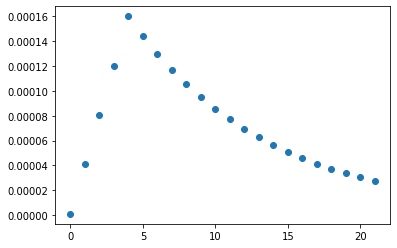

In [20]:
def get_lr_callback(plot=False):
    lr_start   = 0.000001
    lr_max     = 0.000005 * config.BATCH_SIZE # 32  
    lr_min     = 0.000001
    lr_ramp_ep = 4
    lr_sus_ep  = 0
    lr_decay   = 0.9
   
    def lrfn(epoch):
        if config.RESUME:
            epoch = epoch + config.RESUME_EPOCH
        if epoch < lr_ramp_ep:
            lr = (lr_max - lr_start) / lr_ramp_ep * epoch + lr_start
            
        elif epoch < lr_ramp_ep + lr_sus_ep:
            lr = lr_max
            
        else:
            lr = (lr_max - lr_min) * lr_decay**(epoch - lr_ramp_ep - lr_sus_ep) + lr_min
            
        return lr
        
    if plot:
        epochs = list(range(config.EPOCHS))
        learning_rates = [lrfn(x) for x in epochs]
        plt.scatter(epochs,learning_rates)
        plt.show()

    lr_callback = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose=False)
    return lr_callback

get_lr_callback(plot=True)

In [21]:
class Snapshot(tf.keras.callbacks.Callback):
    
    def __init__(self,fold,snapshot_epochs=[]):
        super(Snapshot, self).__init__()
        self.snapshot_epochs = snapshot_epochs
        self.fold = fold
        
    def on_epoch_end(self, epoch, logs=None):
        # logs is a dictionary
#         print(f"epoch: {epoch}, train_acc: {logs['acc']}, valid_acc: {logs['val_acc']}")
        if epoch in self.snapshot_epochs: # your custom condition         
            self.model.save_weights(config.save_dir+f"/EF{config.MODEL_NAME}_epoch{epoch}.h5")
        self.model.save_weights(config.save_dir+f"/{config.MODEL_NAME}_last.h5")

# Train

In [22]:
TRAINING_FILENAMES = [x for i,x in enumerate(train_files) if i%config.FOLDS!=config.FOLD_TO_RUN]
VALIDATION_FILENAMES = [x for i,x in enumerate(train_files) if i%config.FOLDS==config.FOLD_TO_RUN]
print(len(TRAINING_FILENAMES),len(VALIDATION_FILENAMES),count_data_items(TRAINING_FILENAMES),count_data_items(VALIDATION_FILENAMES))

8 2 40826 10207


In [23]:
if config.DEBUG:
    TRAINING_FILENAMES = [TRAINING_FILENAMES[0]]
    VALIDATION_FILENAMES = [VALIDATION_FILENAMES[0]]
    print(len(TRAINING_FILENAMES),len(VALIDATION_FILENAMES),count_data_items(TRAINING_FILENAMES),count_data_items(VALIDATION_FILENAMES))
    test_files = [test_files[0]]

In [24]:
seed_everything(config.SEED)
VERBOSE = 1
train_dataset = get_training_dataset(TRAINING_FILENAMES)
val_dataset = get_val_dataset(VALIDATION_FILENAMES)
STEPS_PER_EPOCH = count_data_items(TRAINING_FILENAMES) // config.BATCH_SIZE
train_logger = tf.keras.callbacks.CSVLogger(config.save_dir+'/training-log-fold-%i.h5.csv'%config.FOLD_TO_RUN)
# SAVE BEST MODEL EACH FOLD        
sv_loss = tf.keras.callbacks.ModelCheckpoint(
    config.save_dir+f"/{config.MODEL_NAME}_loss_{config.FOLD_TO_RUN}.h5", monitor='val_loss', verbose=0, save_best_only=True,
    save_weights_only=True, mode='min', save_freq='epoch')
# BUILD MODEL
K.clear_session()
model,embed_model = get_model()
snap = Snapshot(fold=config.FOLD_TO_RUN,snapshot_epochs=[5,8])
model.summary()

if config.RESUME:   
    model.load_weights(config.resume_model_wts)

258080768/258068648 [==============================] - 3s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 inp1 (InputLayer)              [(None, 768, 768, 3  0           []                               
                                )]                                                                
                                                                                                  
 efficientnet-b7 (Functional)   (None, None, None,   64097680    ['inp1[0][0]']                   
                                2560)                                                             
                                                                                                  
 global_average_pooling2d (Glob  (None, 2560)        0           ['efficientnet-b7[0][0]']        
 alAveragePooling2D)       

In [24]:
print('#### Image Size %i with EfficientNet B%i and batch_size %i'%
      (config.IMAGE_SIZE,config.EFF_NET,config.BATCH_SIZE))

history = model.fit(train_dataset,
                validation_data = val_dataset,
                steps_per_epoch = STEPS_PER_EPOCH,
                epochs = config.EPOCHS,
                callbacks = [snap,get_lr_callback(),train_logger,sv_loss], 
                # callbacks = [get_lr_callback()],
                verbose = VERBOSE)
                


#### Image Size 768 with EfficientNet B7 and batch_size 32
Epoch 1/22
   6/1275 [..............................] - ETA: 23:22 - loss: 19.2482 - sparse_categorical_accuracy: 0.0000e+00 - sparse_top_k_categorical_accuracy: 0.0000e+00WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0148s vs `on_train_batch_end` time: 26.9543s). Check your callbacks.


1275/1275 [==============================] - 1786s 1s/step - loss: 19.1528 - sparse_categorical_accuracy: 0.0000e+00 - sparse_top_k_categorical_accuracy: 0.0000e+00 - val_loss: 19.0231 - val_sparse_categorical_accuracy: 0.0000e+00 - val_sparse_top_k_categorical_accuracy: 0.0000e+00 - lr: 1.0000e-06
Epoch 2/22
1275/1275 [==============================] - 1527s 1s/step - loss: 17.7969 - sparse_categorical_accuracy: 0.0000e+00 - sparse_top_k_categorical_accuracy: 0.0000e+00 - val_loss: 18.2821 - val_sparse_categorical_accuracy: 0.0000e+00 - val_sparse_top_k_categorical_accuracy: 0.0000e+00 - lr: 4.0750e-05
Epoch 3/22
1275/1275 [==============================] - 1526s 1s/step - loss: 17.2598 - sparse_categorical_accuracy: 0.0000e+00 - sparse_top_k_categorical_accuracy: 0.0000e+00 - val_loss: 17.6738 - val_sparse_categorical_accuracy: 0.0000e+00 - val_sparse_top_k_categorical_accuracy: 0.0000e+00 - lr: 8.0500e-05
Epoch 4/22
1275/1275 [==============================] - 1525s 1s/step - loss: 

In [ ]:
#with open(config.save_dir+f'train_{filename.split("/")[-1]}_{config.FOLD_TO_RUN}.npy', 'rb') as f:


In [ ]:
# model.load_weights(config.save_dir+f"/{config.MODEL_NAME}_loss.h5")
# embed_models=[]
# for i in range(5):
#    model,embed_model = get_model()
#    embed_models.append((model.load_weights(f"/content/drive/Othercomputers/MyComputer/workspace/dl_whale_classification/experiments-0/20220310-073407/effnetv1_b5_loss_{i}.h5"),embed_model))

In [49]:
model,embed_model = get_model()
model, embed_model = (model.load_weights(f"/content/effnetv1_b7_loss_25.h5"),embed_model)

# Evaluation

In [50]:
def better_than_median(inputs, axis):
    """Compute the mean of the predictions if there are no outliers,
    or the median if there are outliers.

    Parameter: inputs = ndarray of shape (n_samples, n_folds)"""
    spread = inputs.max(axis=axis) - inputs.min(axis=axis) 
    spread_lim = 0.45
    print(f"Inliers:  {(spread < spread_lim).sum():7} -> compute mean")
    print(f"Outliers: {(spread >= spread_lim).sum():7} -> compute median")
    print(f"Total:    {len(inputs):7}")
    return np.where(spread < spread_lim,
                    np.mean(inputs, axis=axis),
                    np.median(inputs, axis=axis))

In [51]:
def get_ids(filename):
    ds = get_test_dataset([filename],get_names=True).map(lambda image, image_name: image_name).unbatch()
    NUM_IMAGES = count_data_items([filename])
    ids = next(iter(ds.batch(NUM_IMAGES))).numpy().astype('U')
    return ids

def get_targets(filename):
    ds = get_eval_dataset([filename],get_targets=True).map(lambda image, target: target).unbatch()
    NUM_IMAGES = count_data_items([filename])
    ids = next(iter(ds.batch(NUM_IMAGES))).numpy()
    return ids

def get_embeddings(filename):
    ds = get_test_dataset([filename],get_names=False)
    embeddings = np.mean(np.stack([embed_models[x][1].predict(ds,verbose=0) for x in range(5)]), axis=0)
    #print (embeddings.shape)
    return embeddings

def get_embeddings_np(filename,data_types='train',kfold_list=[x for x in range(5)],dataset='../input/eff7-new-768'):#x for x in range(6)
    ds = get_test_dataset([filename],get_names=False)

    # embeddings = np.mean(np.stack([embed_models[x][1].predict(ds,verbose=0) for x in range(5)]), axis=0)
    embeddings = embed_model.predict(ds, verbose=0)
    print (embeddings.shape)
    val_train={'train':'val','val':'train','test':'test'}
    embeddings=[]
    for kfold in kfold_list:
        path=f'{dataset}/{data_types}_{filename.split("/")[-1]}_{kfold}.npy'
        if os.path.exists(path):
            print(path)
            with open(path, 'rb') as f:
                embeddings.append(np.load(f))
        else:
            path=f'{dataset}/{val_train[data_types]}_{filename.split("/")[-1]}_{kfold}.npy'
            if os.path.exists(path):
                print(path)
                with open(path, 'rb') as f:
                    embeddings.append(np.load(f))
                
    print (len(embeddings))
    # embeddings = np.mean(np.stack(embeddings), axis=0)
    #embeddings = np.median(np.stack(embeddings), axis=0)
    #embeddings = better_than_median(np.stack(embeddings), axis=0)
    
    return embeddings

def get_predictions(test_df,threshold=0.2):
    predictions = {}
    for i,row in tqdm(test_df.iterrows()):
        if row.image in predictions:
            if len(predictions[row.image])==5:
                continue
            predictions[row.image].append(row.target)
        elif row.confidence>threshold:
            predictions[row.image] = [row.target,'new_individual']
        else:
            predictions[row.image] = ['new_individual',row.target]

    for x in tqdm(predictions):
        if len(predictions[x])<5:
            remaining = [y for y in sample_list if y not in predictions]
            predictions[x] = predictions[x]+remaining
            predictions[x] = predictions[x][:5]
        
    return predictions

def map_per_image(label, predictions):
    """Computes the precision score of one image.

    Parameters
    ----------
    label : string
            The true label of the image
    predictions : list
            A list of predicted elements (order does matter, 5 predictions allowed per image)

    Returns
    -------
    score : double
    """    
    try:
        return 1 / (predictions[:5].index(label) + 1)
    except ValueError:
        return 0.0
    
f = open ('/content/drive/Othercomputers/MyComputer/workspace/dl_whale_classification/individual_ids.json', "r")
target_encodings = json.loads(f.read())
target_encodings = {target_encodings[x]:x for x in target_encodings}
sample_list = ['938b7e931166', '5bf17305f073', '7593d2aee842', '7362d7a01d00','956562ff2888']

In [52]:
embed_model

In [53]:
train_targets = []
train_embeddings = []
for filename in tqdm(TRAINING_FILENAMES[:4]): # TRAINING_FILENAMES
    # embeddings = get_embeddings_np(filename)
    ds = get_test_dataset([filename],get_names=False)
    embeddings = embed_model.predict(ds)
    targets = get_targets(filename)
    train_embeddings.append(embeddings)
    train_targets.append(targets)
train_embeddings = np.concatenate(train_embeddings)
train_targets = np.concatenate(train_targets)

  0%|          | 0/4 [00:00<?, ?it/s]

In [54]:
from sklearn.neighbors import NearestNeighbors
neigh = NearestNeighbors(n_neighbors=400,metric='cosine')
neigh.fit(train_embeddings)

NearestNeighbors(metric='cosine', n_neighbors=400)

In [55]:
test_ids = []
test_nn_distances = []
test_nn_idxs = []
val_targets = []
val_embeddings = []
for filename in tqdm(VALIDATION_FILENAMES[:1]):#(VALIDATION_FILENAMES):
    # embeddings = get_embeddings_np(filename,'val')
    ds = get_test_dataset([filename],get_names=False)
    embeddings = embed_model.predict(ds)
    targets = get_targets(filename)
    ids = get_ids(filename)
    distances,idxs = neigh.kneighbors(embeddings, config.KNN, return_distance=True)
    test_ids.append(ids)
    test_nn_idxs.append(idxs)
    test_nn_distances.append(distances)
    val_embeddings.append(embeddings)
    val_targets.append(targets)
test_nn_distances = np.concatenate(test_nn_distances)
test_nn_idxs = np.concatenate(test_nn_idxs)
test_ids = np.concatenate(test_ids)
val_embeddings = np.concatenate(val_embeddings)
val_targets = np.concatenate(val_targets)

  0%|          | 0/1 [00:00<?, ?it/s]

In [56]:
allowed_targets = set([target_encodings[x] for x in np.unique(train_targets)])
val_targets_df = pd.DataFrame(np.stack([test_ids,val_targets],axis=1),columns=['image','target'])
val_targets_df['target'] = val_targets_df['target'].astype(int).map(target_encodings)
val_targets_df.loc[~val_targets_df.target.isin(allowed_targets),'target'] = 'new_individual'
val_targets_df.target.value_counts()

new_individual    2121
37c7aba965a5        79
ffbb4e585ff2        44
281504409737        41
c27db73f0e3b        36
                  ... 
a39c690e9a90         1
7426577f8204         1
71966e57f940         1
fca4fa5e1778         1
393d638cb589         1
Name: target, Length: 3286, dtype: int64

In [57]:
test_df = []
for i in tqdm(range(len(test_ids))):
    id_ = test_ids[i]
    targets = train_targets[test_nn_idxs[i]]
    distances = test_nn_distances[i]
    subset_preds = pd.DataFrame(np.stack([targets,distances],axis=1),columns=['target','distances'])
    subset_preds['image'] = id_
    test_df.append(subset_preds)
test_df = pd.concat(test_df).reset_index(drop=True)
test_df['confidence'] = 1-test_df['distances']
test_df = test_df.groupby(['image','target']).confidence.max().reset_index()
test_df = test_df.sort_values('confidence',ascending=False).reset_index(drop=True)
test_df['target'] = test_df['target'].map(target_encodings)
test_df.to_csv('val_neighbors.csv')
test_df.image.value_counts().value_counts()

  0%|          | 0/10207 [00:00<?, ?it/s]

493    49
454    47
417    47
415    46
452    45
       ..
676     1
675     1
631     1
758     1
95      1
Name: image, Length: 580, dtype: int64

In [58]:
## Compute CV
best_th = 0
best_cv = 0
for th in [0.5 + 0.05*x for x in range(12)]:
    all_preds = get_predictions(test_df,threshold=th)
    cv = 0
    for i,row in val_targets_df.iterrows():
        target = row.target
        preds = all_preds[row.image]
        val_targets_df.loc[i,th] = map_per_image(target,preds)
    cv = val_targets_df[th].mean()
    print(f"CV at threshold {th}: {cv}")
    if cv>best_cv:
        best_th = th
        best_cv = cv

0it [00:00, ?it/s]

  0%|          | 0/10207 [00:00<?, ?it/s]

CV at threshold 0.5: 0.6575144508670472


0it [00:00, ?it/s]

  0%|          | 0/10207 [00:00<?, ?it/s]

CV at threshold 0.55: 0.6575144508670472


0it [00:00, ?it/s]

  0%|          | 0/10207 [00:00<?, ?it/s]

CV at threshold 0.6: 0.661335358087582


0it [00:00, ?it/s]

  0%|          | 0/10207 [00:00<?, ?it/s]

CV at threshold 0.65: 0.6914127559517919


0it [00:00, ?it/s]

  0%|          | 0/10207 [00:00<?, ?it/s]

CV at threshold 0.7: 0.7218330557460502


0it [00:00, ?it/s]

  0%|          | 0/10207 [00:00<?, ?it/s]

CV at threshold 0.75: 0.7107622220045002


0it [00:00, ?it/s]

  0%|          | 0/10207 [00:00<?, ?it/s]

CV at threshold 0.8: 0.6750024492994942


0it [00:00, ?it/s]

  0%|          | 0/10207 [00:00<?, ?it/s]

CV at threshold 0.8500000000000001: 0.6292495346330896


0it [00:00, ?it/s]

  0%|          | 0/10207 [00:00<?, ?it/s]

CV at threshold 0.9: 0.5779122171059037


0it [00:00, ?it/s]

  0%|          | 0/10207 [00:00<?, ?it/s]

CV at threshold 0.95: 0.5226070343881624


0it [00:00, ?it/s]

  0%|          | 0/10207 [00:00<?, ?it/s]

CV at threshold 1.0: 0.4965464877045147


0it [00:00, ?it/s]

  0%|          | 0/10207 [00:00<?, ?it/s]

CV at threshold 1.05: 0.4965464877045147


In [59]:
print("Best threshold",best_th)
print("Best cv",best_cv)
val_targets_df.describe()

Best threshold 0.7
Best cv 0.7218330557460502


,0.5,0.55,0.6,0.65,0.7,0.75,0.8,0.8500000000000001,0.9,0.95,1.0,1.05
count,10207.000000,10207.000000,10207.000000,10207.000000,10207.000000,10207.000000,10207.000000,10207.000000,10207.000000,10207.000000,10207.000000,10207.000000
mean,0.657514,0.657514,0.661335,0.691413,0.721833,0.710762,0.675002,0.629250,0.577912,0.522607,0.496546,0.496546
std,0.395579,0.395579,0.396453,0.402000,0.405270,0.404348,0.399264,0.387885,0.367994,0.336637,0.317477,0.317477
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.333333,0.333333,0.333333,0.333333,0.333333,0.333333,0.333333,0.333333,0.333333,0.333333,0.333333,0.333333
50%,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.500000,0.500000,0.500000,0.500000,0.500000
75%,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.500000,0.500000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [60]:
## Adjustment: Since Public lb has nearly 10% 'new_individual' (Be Careful for private LB)
val_targets_df['is_new_individual'] = val_targets_df.target=='new_individual'
print(val_targets_df.is_new_individual.value_counts().to_dict())
val_scores = val_targets_df.groupby('is_new_individual').mean().T
val_scores['adjusted_cv'] = val_scores[True]*0.1+val_scores[False]*0.9
best_threshold_adjusted = val_scores['adjusted_cv'].idxmax()
print("best_threshold",best_threshold_adjusted)
val_scores

{False: 8086, True: 2121}
best_threshold 0.7


is_new_individual,False,True,adjusted_cv
0.5,0.698831,0.500000,0.678948
0.55,0.698831,0.500000,0.678948
0.6,0.698769,0.518623,0.680755
0.65,0.695430,0.676096,0.693497
0.7,0.677745,0.889910,0.698962
0.75,0.640273,0.979491,0.674195
0.8,0.590496,0.997171,0.631163
0.8500000000000001,0.532062,0.999764,0.578832
0.9,0.467196,1.000000,0.520477
0.95,0.397384,1.000000,0.457646


# Inference

In [61]:
train_embeddings = np.concatenate([train_embeddings,val_embeddings])
train_targets = np.concatenate([train_targets,val_targets])
print(train_embeddings.shape,train_targets.shape)

(51033, 512) (51033,)


In [62]:
from sklearn.neighbors import NearestNeighbors
neigh = NearestNeighbors(n_neighbors=config.KNN,metric='cosine')
neigh.fit(train_embeddings)

NearestNeighbors(metric='cosine', n_neighbors=1000)

In [63]:
test_ids = []
test_nn_distances = []
test_nn_idxs = []
for filename in tqdm(test_files):
    # embeddings = get_embeddings_np(filename,'test')
    ds = get_test_dataset([filename],get_names=False)
    embeddings = embed_model.predict(ds)
    ids = get_ids(filename)
    distances,idxs = neigh.kneighbors(embeddings, config.KNN, return_distance=True)
    test_ids.append(ids)
    test_nn_idxs.append(idxs)
    test_nn_distances.append(distances)
test_nn_distances = np.concatenate(test_nn_distances)
test_nn_idxs = np.concatenate(test_nn_idxs)
test_ids = np.concatenate(test_ids)

  0%|          | 0/10 [00:00<?, ?it/s]

In [64]:
sample_submission = pd.read_csv('/content/drive/MyDrive/input/sample_submission.csv',index_col='image')
print(len(test_ids),len(sample_submission))
test_df = []
for i in tqdm(range(len(test_ids))):
    id_ = test_ids[i]
    targets = train_targets[test_nn_idxs[i]]
    distances = test_nn_distances[i]
    subset_preds = pd.DataFrame(np.stack([targets,distances],axis=1),columns=['target','distances'])
    subset_preds['image'] = id_
    test_df.append(subset_preds)
test_df = pd.concat(test_df).reset_index(drop=True)
test_df['confidence'] = 1-test_df['distances']
test_df = test_df.groupby(['image','target']).confidence.max().reset_index()
test_df = test_df.sort_values('confidence',ascending=False).reset_index(drop=True)
test_df['target'] = test_df['target'].map(target_encodings)
test_df.to_csv('test_neighbors.csv')
test_df.image.value_counts().value_counts()

27956 27956


  0%|          | 0/27956 [00:00<?, ?it/s]

466    124
436    122
416    120
430    119
412    119
      ... 
726      1
721      1
720      1
716      1
99       1
Name: image, Length: 648, dtype: int64

In [65]:
sample_list = ['938b7e931166', '5bf17305f073', '7593d2aee842', '7362d7a01d00','956562ff2888']

In [66]:
predictions = {}
for i,row in tqdm(test_df.iterrows()):
    if row.image in predictions:
        if len(predictions[row.image])==5:
            continue
        predictions[row.image].append(row.target)
    elif row.confidence>best_threshold_adjusted:#best_threshold_adjusted
        predictions[row.image] = [row.target,'new_individual']
    else:
        predictions[row.image] = ['new_individual',row.target]
        
for x in tqdm(predictions):
    if len(predictions[x])<5:
        remaining = [y for y in sample_list if y not in predictions]
        predictions[x] = predictions[x]+remaining
        predictions[x] = predictions[x][:5]
    predictions[x] = ' '.join(predictions[x])
    
predictions = pd.Series(predictions).reset_index()
predictions.columns = ['image','predictions']
predictions.to_csv('submission_.csv',index=False)
predictions.head()

0it [00:00, ?it/s]

  0%|          | 0/27956 [00:00<?, ?it/s]

,image,predictions
0,d846a86edded63.jpg,03a3bbaeed84 new_individual 52a2c490b25a 78211...
1,80d34a911209bc.jpg,47a2f9918aa2 new_individual 73c68d52e748 a73cd...
2,dd806b5d0f42e1.jpg,13e453fd9598 new_individual 5cd9d3739ccf e3058...
3,1e2985de58a097.jpg,3f483882f6a0 new_individual 5e62d23d8068 9e193...
4,3c52966f74d2ad.jpg,978520860ceb new_individual a74a0cbf40fc cfd34...


In [ ]:
print (test_df)